<a href="https://colab.research.google.com/github/fhac-ewi/recurrent-neural-network/blob/main/%C3%9Cbung_RNN_L%C3%B6sung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung RNN

## In dieser Übung ...
... werden wir ein bisschen lyrisch. Am Ende werden Sie vielleicht noch der nächste Shakespear






In [ ]:
# Kind of important imports

import tensorflow as tf
import keras
import numpy as np
import sys
import matplotlib.pyplot as plt

In [ ]:
# Additional, nice to have, imports

from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
import time

In [ ]:
# Check for GPU support and Versions you are using so debugging is easier

from tensorflow.python.client import device_lib
physical_devices = device_lib.list_local_devices()
print("Keras Version:", keras.__version__, "; Tensorflow version:", tf.__version__, "; NumPy version:", np.__version__, "Python version:", ".".join(str(x) for x in sys.version_info[:3]))
print("You are using", len(physical_devices), "local devises.", len([x for x in physical_devices if x.device_type == "GPU"]), "are GPUs")
for i, d in enumerate(physical_devices):
    print("  ->Device", i+1, "is a", d.device_type, "=>", d.physical_device_desc if len(d.physical_device_desc) > 0 else d.name)

Keras Version: 2.4.3 ; Tensorflow version: 2.4.1 ; NumPy version: 1.19.5 Python version: 3.7.10
You are using 2 local devises. 1 are GPUs
  ->Device 1 is a CPU => /device:CPU:0
  ->Device 2 is a GPU => device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


## x.1 Erstellen und Vorbereiten eines eigenen Datensatzes 

Zuerst müssen wir ein paar Daten über die Werke von Shakespear besorgen

**Ihre Aufgaben**

Führen Sie die folgende Codezelle aus, betrachten Sie den Datensatz und überlegen Sie, was Sie mit den Daten noch tun müssen

Hinweis: Müssen Sie die Techte noch etwas bereinigen?

In [ ]:
MAX_TEXT_LEN = 100_000 # You are going to kill the poor RAM
# We could make adjustments here so the initial dataset is small so fast training and give the annotation to increase it once everything works as expected on the small one maybe

#path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
path_to_file = tf.keras.utils.get_file('german_news.txt', 'https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv') # Taken from https://github.com/tblock/10kGNAD

text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(text)} characters')
if len(text) > MAX_TEXT_LEN:
    print("Text is too long. Cutting it to", MAX_TEXT_LEN, f"characters. That is{100 * MAX_TEXT_LEN / len(text):6.2f}%")
    text = text[:MAX_TEXT_LEN]

Length of text: 26733346 characters
Text is too long. Cutting it to 100000 characters. That is  0.37%


In [ ]:
print(text[:250])

Etat;Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, soll


Wir werden der einfach heit halber einzelne Zeichen vorhersagen. Unser vokabular sollte also aus allen Zeichen bestehen, die im text vorkommen

Hinweis: Vielleicht kann https://spacy.io/usage/spacy-101 hilfreich sein

In [ ]:
def tokenize(text):
    return list(text)

def untokenize(tokens):
    return "".join(tokens)

In [ ]:
tokenized_text = tokenize(text)

tokens = sorted(set(tokenized_text))

print("Length of raw text:", len(text))
print("Length of tokenized text:", len(tokenized_text))
print("Unique tokens:", len(tokens))


Length of raw text: 100000
Length of tokenized text: 100000
Unique tokens: 98


## x.2 One Hot Kodierung

Für das Training unseres RNN werden wir eine One Hot kodierung nutzen

**Ihre Aufgaben**

(1) Implementieren Sie also eine Methode, die für Ihre ausgewählten Tokens eine one hot codierung erzeigt und diese Dann auf den Text anwendet

*Himweis:* Eine gute Idee könnte sein eine Klasse zu schreiben, die das vokabular specichert und onehot kodieren und dekodieren kann

In [ ]:
class OneHot(object):
    def __init__(self, tokens, unknown_token = "[UNKNOWN]"):
        '''
        tokens: The tokens you want to be able to encode and decode
        unknown_token: The token to be used when decoding and the net wants to use a not known char
        '''
        self.tokens = tokens
        self.unknown_token = unknown_token
        # Store a bidirectional dictionary containing the characters
        self.char_to_index = dict((token, i + 1) for i, token in enumerate(self.tokens))
        self.index_to_char = dict((i + 1, token) for i, token in enumerate(self.tokens))
        pass

    def encode(self, text_as_tokens, dtype=np.bool_):
        '''
        text_as_tokens: List of tokens
        '''
        # Create the encoding matrix
        enc = np.empty((len(text_as_tokens), len(self.tokens) + 1), dtype=dtype)
        for i, token in enumerate(text_as_tokens):
            # Encode every char
            enc[i] = self.encode_token(token=token, l=len(self.tokens) + 1, dtype=dtype)
        return enc
    
    def encode_token(self, token, l, dtype=np.bool_):
        '''
        token: Single token
        l: length of array to be returned. At position zero it is stored if the char is unknown
        '''
        ret = np.zeros((1, l), dtype=dtype)
        if token not in self.char_to_index:
            ret[0, 0] = 1
        else:
            ret[0, self.char_to_index[token]] = 1
        return ret
    
    def decode(self, mat, unknown_token=None):         
        '''
        mat: matrix to be decoded. Has to be of shape (len_of_text, vocab_size)
        unknown_token: Unknown token. If none uses the one from __init__
        '''
        return [self.decode_token(mat[x]) for x in range(mat.shape[0])]
    
    def decode_token(self, vec, unknown_token=None):
        '''
        vec: Vector that should be decoded. Has to be on vocab length
        unknown_token: Unknown token. If none uses the one from __init__
        '''
        if unknown_token is None:
            unknown_token = self.unknown_token
        if isinstance(vec, tf.Tensor):
            vec = vec.numpy()
        if isinstance(vec, np.ndarray):
            # Use argmax since this will be used in the model created later
            am = np.argmax(vec)
        else:
            am = vec
        if am == 0:
            return unknown_token
        return self.index_to_char[am]

In [ ]:
one_hot = OneHot(tokens=tokens)

In [ ]:
one_hot_text = one_hot.encode(tokenized_text, dtype=np.bool_)

print(one_hot_text.shape, one_hot_text.dtype)

(100000, 99) bool


(2) Für das training brauchen wir nun sequenzen einer bestimmten Länge, das heißt eine Abfolge gegebener Länge von Wörtern

Hinweis: Überlegen Sie sich wie lang Sie die Sequenz wählen wollen. Es sollte lang genug sein, dass das Netz zusammen hänge auch über mehrere Sätze lernen kann, aber nicht zu lang, sodass noch genug von den Daten übrig bleibt

In [ ]:
sequence_len = 125
target_shape = (int(one_hot_text.shape[0] / (sequence_len + 1)) , (sequence_len + 1) , one_hot_text.shape[1])

one_hot_text_seq = np.empty(target_shape, dtype=one_hot_text.dtype)

for s in range(one_hot_text_seq.shape[0]):
    one_hot_text_seq[s] = one_hot_text[s * (sequence_len + 1):(s + 1) * (sequence_len + 1)]

(3) Nun müssen wir die Daten noch in X und Y aufteilen. Die Y-Werte sind die gleichen, wie die jeweiligen X-Daten, nur um 1 verschoben.

*Beispiel:* X: "Hallo Wel"; Y: "allo Welt"

*Hinweis:* Wenn Sie möchten können Sie hier auch schon in trainings und validierungsdaten aufteilen. Diese können während dem training zur Bewertung der Performance genutzt werden, das ist aber nicht nötig

In [ ]:
VALIDATION_SIZE = 1/5

X_train, X_val, y_train, y_val = train_test_split(one_hot_text_seq[:, :-1], one_hot_text_seq[:, 1:], test_size=VALIDATION_SIZE)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_val  :", X_val.shape, X_val.dtype)
print("y_val  :", y_val.shape, y_val.dtype)

print("-" * 25)
print(untokenize(one_hot.decode(X_train[0])))
print("-" * 25)
print(untokenize(one_hot.decode(y_train[0])))
print("-" * 25)

X_train: (634, 125, 99) bool
y_train: (634, 125, 99) bool
X_val  : (159, 125, 99) bool
y_val  : (159, 125, 99) bool
-------------------------
 für Medienkritik an – unter Einbeziehung der Leser. Auf seinem Blog schreibt Niggemeier, dass er zwar das Projekt Krautrepor
-------------------------
für Medienkritik an – unter Einbeziehung der Leser. Auf seinem Blog schreibt Niggemeier, dass er zwar das Projekt Krautreport
-------------------------


## x.3 Erstellen des RNN Modells

Hier erstellen wir das eigentliche RNN. Hierfür nutzen wir ein Sequential Model von Keras mit einem RNN und einem Dense Layer mit Softmax zum erstellen der Ausgabe.

**Ihre Aufgaben**

(1) Erstellen Sie das entsprechende Sequential model. Empfehlung mit adam und categorical_crossentropy. Fügen Sie bei den metrics auch 'accuracy' hinzu. Die werden wir später nutzen

In [ ]:
# Length of the vocabulary in chars
vocab_size = X_train.shape[-1]

# The input shape
lstn_input_shape = X_train.shape[1:]

# Number of RNN units
rnn_units = 1024

In [ ]:
model = tf.keras.Sequential(name="SimpleRNN_Model")
model.add(tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, input_shape=lstn_input_shape, name="The_Brain"))
model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = model.predict(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(X_train[0])), "\n", "-"*25)
print("Expected result:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(y_train[0])), "\n", "-"*25)
print("Untrained prediction:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(example_batch_predictions[0])), "\n", "-"*25)

Model: "SimpleRNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (SimpleRNN)        (None, 125, 1024)         1150976   
_________________________________________________________________
The_Hand (Dense)             (None, 125, 99)           101475    
Total params: 1,252,451
Trainable params: 1,252,451
Non-trainable params: 0
_________________________________________________________________
(1, 125, 99) (125, 99) (1, 125, 99)
Test sequence: 
 ------------------------- 
  für Medienkritik an – unter Einbeziehung der Leser. Auf seinem Blog schreibt Niggemeier, dass er zwar das Projekt Krautrepor 
 -------------------------
Expected result: 
 ------------------------- 
 für Medienkritik an – unter Einbeziehung der Leser. Auf seinem Blog schreibt Niggemeier, dass er zwar das Projekt Krautreport 
 -------------------------
Untrained prediction: 
 ------------------------- 
?5I0vm©öNá'o,E–N

## x.4 Training eines RNN Modells

Nun gehts ans trainieren. Nutzen Sie für den Anfang eine kleine Anzahl an epochen um herauszufinden wie viele Sie in einer ertragbaren Zeit machen können. Sollten Sie auf google Colab arbeiten könnte 20 hier ein guter Startwert sein

**Ihre Aufgaben**

(1) Nutze die Fit methode deines models um es auf den ertellten Trainingsdaten zu trainieren. Wenn Sie validierungsdaten erzeugt haben können Sie diese bei validation_data angeben. Um die Trainingszeit kurz zu halten kann es auch Sinn ergeben hier eine batch_size anzugeben

In [ ]:
EPOCHS = 40
BATCH_SIZE = 64

In [ ]:
t1 = time.time()
hist = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val, y_val))
t2 = time.time()

print("Training took:", timedelta(seconds=t2-t1))

Epoch 1/40
10/10 [==============================] - 2s 140ms/step - loss: 4.1556 - accuracy: 0.0696 - val_loss: 3.5039 - val_accuracy: 0.0791
Epoch 2/40
10/10 [==============================] - 1s 87ms/step - loss: 3.3883 - accuracy: 0.1194 - val_loss: 3.2907 - val_accuracy: 0.2005
Epoch 3/40
10/10 [==============================] - 1s 86ms/step - loss: 3.2669 - accuracy: 0.1678 - val_loss: 3.2302 - val_accuracy: 0.2045
Epoch 4/40
10/10 [==============================] - 1s 89ms/step - loss: 3.2273 - accuracy: 0.1941 - val_loss: 3.1954 - val_accuracy: 0.1959
Epoch 5/40
10/10 [==============================] - 1s 86ms/step - loss: 3.1963 - accuracy: 0.1923 - val_loss: 3.1589 - val_accuracy: 0.2072
Epoch 6/40
10/10 [==============================] - 1s 86ms/step - loss: 3.1447 - accuracy: 0.2042 - val_loss: 3.1104 - val_accuracy: 0.2076
Epoch 7/40
10/10 [==============================] - 1s 86ms/step - loss: 3.1121 - accuracy: 0.2014 - val_loss: 3.0597 - val_accuracy: 0.2252
Epoch 8/40
1

(2) Plotten Sie accuracy und loss über die Epochen um bewerten zu können wie gut das Training lief

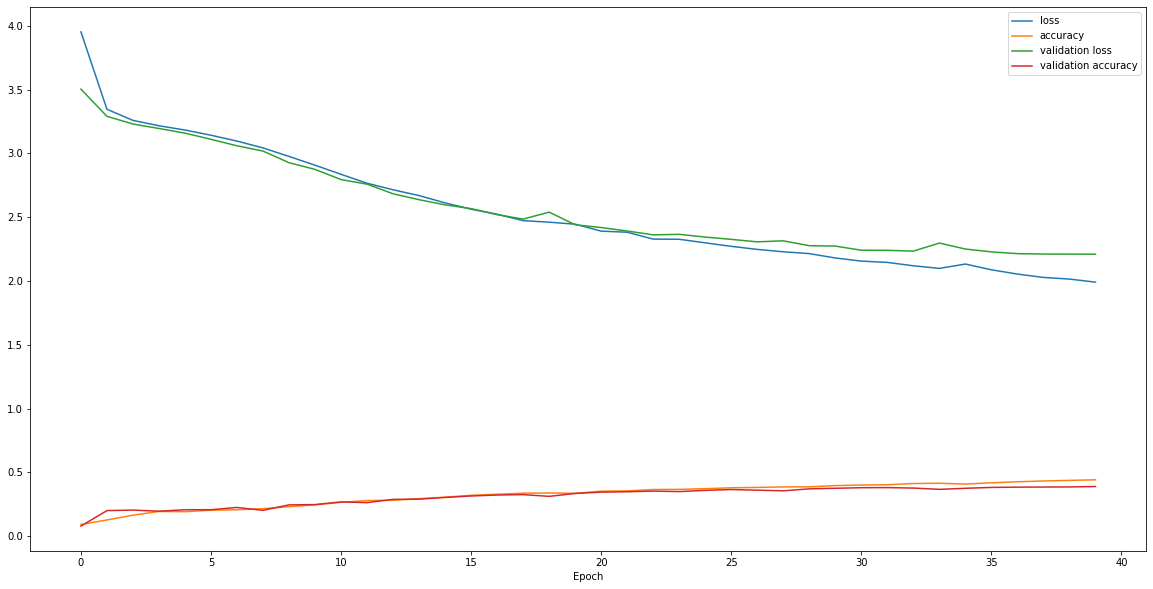

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist.history["loss"], label='loss')
ax.plot(hist.history["accuracy"], label='accuracy')
ax.plot(hist.history["val_loss"], label='validation loss')
ax.plot(hist.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

## x.5 Text prediction

(1) Schreiben Sie eine Methode, die für einen gegebenen Text das nächste Zeichen prognostiziert

In [ ]:
def predict(txt, one_hot, trainied_model):
    encoded_txt = one_hot.encode(tokenize(txt))
    prediction = trainied_model.predict(encoded_txt.reshape((1, *encoded_txt.shape)))
    return untokenize(one_hot.decode(prediction[0]))[-1]

(2) *Optional:* Nutzen Sie ipywidgets um live vorschläge zurück zu geben

In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
def verbose_prediction(txt, one_hot, trainied_model):
    if len(txt) == 0:
        txt = " "
    prediction = predict(txt=txt, one_hot=one_hot, trainied_model=trainied_model)
    print(f"I think the next will be \"{prediction}\" after you said \"{txt}\"")

w = widgets.interactive(verbose_prediction,
                        txt=widgets.Text(value='Hello Worl', placeholder='Type something', description='Your text:', disabled=False),
                        one_hot=widgets.fixed(one_hot),
                        trainied_model=widgets.fixed(model),
                       )

verbose_prediction("Spor", one_hot=one_hot, trainied_model=model)
verbose_prediction("Fußba", one_hot=one_hot, trainied_model=model)

display(w)

I think the next will be "i" after you said "Spor"
I think the next will be "l" after you said "Fußba"


interactive(children=(Text(value='Hello Worl', description='Your text:', placeholder='Type something'), Output…

## x.6 *Optional* Vergleich mit LSTM und GRU und ...

Trainieren Sie nun modelle mit LSTM und GRU oder anderen Architekturen und vergleichen Sie lernperformance und Ergebnisse. Was fällt Ihnen auf?

In [ ]:
model_lstm = tf.keras.Sequential(name="LSTM_Model")
model_lstm.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True, input_shape=lstn_input_shape, name="The_Brain"))
model_lstm.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

model_gru = tf.keras.Sequential(name="GRU_Model")
model_gru.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True, input_shape=lstn_input_shape, name="The_Brain"))
model_gru.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()


Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (LSTM)             (None, 125, 1024)         4603904   
_________________________________________________________________
The_Hand (Dense)             (None, 125, 99)           101475    
Total params: 4,705,379
Trainable params: 4,705,379
Non-trainable params: 0
_________________________________________________________________
Model: "GRU_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (LSTM)             (None, 125, 1024)         4603904   
_________________________________________________________________
The_Hand (Dense)             (None, 125, 99)           101475    
Total params: 4,705,379
Trainable params: 4,705,379
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t1 = time.time()
hist_lstm = model_lstm.fit(X_train, y_train,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=(X_val, y_val))
t2 = time.time()
t_lstm = t2 - t1

t1 = time.time()
hist_gru = model_gru.fit(X_train, y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val))
t2 = time.time()
t_gru = t2 - t1

print("LSTM Training took:", timedelta(seconds=t_lstm))
print("GRU  Training took:", timedelta(seconds=t_gru))

Epoch 1/40
10/10 [==============================] - 4s 136ms/step - loss: 4.2600 - accuracy: 0.0875 - val_loss: 3.3871 - val_accuracy: 0.1347
Epoch 2/40
10/10 [==============================] - 1s 85ms/step - loss: 3.3552 - accuracy: 0.1432 - val_loss: 3.2741 - val_accuracy: 0.1784
Epoch 3/40
10/10 [==============================] - 1s 85ms/step - loss: 3.2614 - accuracy: 0.1869 - val_loss: 3.2322 - val_accuracy: 0.1791
Epoch 4/40
10/10 [==============================] - 1s 85ms/step - loss: 3.2286 - accuracy: 0.1858 - val_loss: 3.2104 - val_accuracy: 0.1974
Epoch 5/40
10/10 [==============================] - 1s 85ms/step - loss: 3.2084 - accuracy: 0.2010 - val_loss: 3.1917 - val_accuracy: 0.2000
Epoch 6/40
10/10 [==============================] - 1s 85ms/step - loss: 3.1858 - accuracy: 0.1999 - val_loss: 3.1753 - val_accuracy: 0.2040
Epoch 7/40
10/10 [==============================] - 1s 85ms/step - loss: 3.1793 - accuracy: 0.2034 - val_loss: 3.1564 - val_accuracy: 0.2005
Epoch 8/40
1

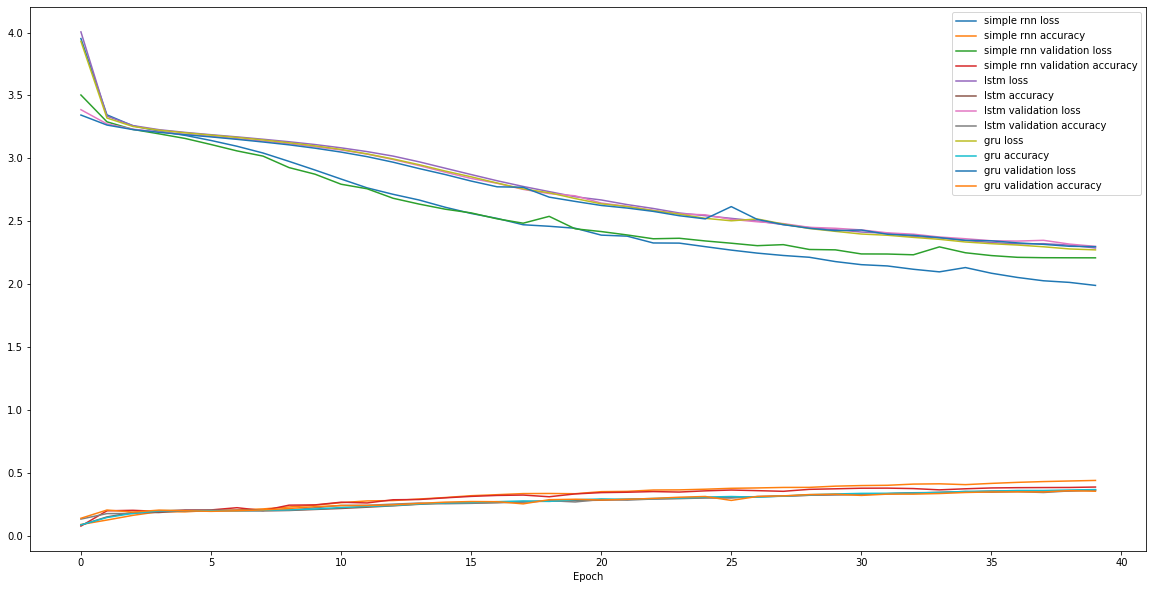

In [ ]:
fig, ax = plt.subplots(1, 1)

for n, h in [("simple rnn", hist), ("lstm", hist_lstm), ("gru", hist_gru)]:

    ax.plot(h.history["loss"], label=f'{n} loss')
    ax.plot(h.history["accuracy"], label=f'{n} accuracy')
    ax.plot(h.history["val_loss"], label=f'{n} validation loss')
    ax.plot(h.history["val_accuracy"], label=f'{n} validation accuracy')

ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

## x.7 *Noch Optionaler* Ist das Netz jetzt ein Schriftsteller?

Was müsste man ändern um nun ein ganzes Buch erstellen zu lassen? Glauben Sie das Ergebniss wäre lesbar?

Hierfür wollen wir wenn möglich beliebig viele Zeichen generieren, dabei den hidden state behalten und nicht konstant das bisher geschriebene als Input wieder einfügen. Deshalb nutzen wir hier eine eigene Klasse für das Netz, die dann die Layer enthält, aber aich den Hidden state zurück geben kann

In [ ]:
class CustomRNNModel(tf.keras.Model):
    def __init__(self, vocab_size, rnn_units, rnn_layer_type = tf.keras.layers.GRU):
        super().__init__(self)
        # Put layers here. We will call them manually but store them here
        self.rnn_layer = rnn_layer_type(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, states=None, return_state=False, training=False):
        # Here we put our input through all out layers
        x = tf.cast(inputs, dtype=float)
        if states is None:
            # Get an initial kind of empty state
            states = self.rnn_layer.get_initial_state(x)
        
        x, states = self.rnn_layer(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [ ]:
literatur_model = CustomRNNModel(vocab_size=vocab_size, rnn_units=rnn_units)

input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = literatur_model.predict(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(X_train[0])), "\n", "-"*25)
print("Expected result:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(y_train[0])), "\n", "-"*25)
print("Untrained prediction:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(example_batch_predictions[0])), "\n", "-"*25)

literatur_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

literatur_model.summary()

(1, 125, 99) (125, 99) (1, 125, 99)
Test sequence: 
 ------------------------- 
  für Medienkritik an – unter Einbeziehung der Leser. Auf seinem Blog schreibt Niggemeier, dass er zwar das Projekt Krautrepor 
 -------------------------
Expected result: 
 ------------------------- 
 für Medienkritik an – unter Einbeziehung der Leser. Auf seinem Blog schreibt Niggemeier, dass er zwar das Projekt Krautreport 
 -------------------------
Untrained prediction: 
 ------------------------- 
R4IáRfffIá@RR7NR(f@ǔIAR(wydRRBxEf@@DDX;;;áAIAIáb'4
Eg7bEáIIE 
 -------------------------
Model: "custom_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    multiple                  3456000   
_________________________________________________________________
dense (Dense)                multiple                  101475    
Total params: 3,557,475
Trainable params: 3,557,475
Non-trainable pa

In [ ]:
t1 = time.time()
hist_custom = literatur_model.fit(X_train, y_train,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=(X_val, y_val))
t2 = time.time()

print("Training took:", timedelta(seconds=t2-t1))

Epoch 1/40
10/10 [==============================] - 4s 269ms/step - loss: 4.5728 - accuracy: 0.1161 - val_loss: 4.3070 - val_accuracy: 0.1863
Epoch 2/40
10/10 [==============================] - 2s 231ms/step - loss: 4.1471 - accuracy: 0.1569 - val_loss: 3.3401 - val_accuracy: 0.1370
Epoch 3/40
10/10 [==============================] - 2s 225ms/step - loss: 3.2897 - accuracy: 0.1471 - val_loss: 3.1944 - val_accuracy: 0.2016
Epoch 4/40
10/10 [==============================] - 2s 244ms/step - loss: 3.1839 - accuracy: 0.1896 - val_loss: 3.1237 - val_accuracy: 0.2198
Epoch 5/40
10/10 [==============================] - 2s 243ms/step - loss: 3.1111 - accuracy: 0.2144 - val_loss: 3.0446 - val_accuracy: 0.2108
Epoch 6/40
10/10 [==============================] - 2s 235ms/step - loss: 3.0304 - accuracy: 0.2182 - val_loss: 2.9562 - val_accuracy: 0.2514
Epoch 7/40
10/10 [==============================] - 2s 231ms/step - loss: 2.9340 - accuracy: 0.2577 - val_loss: 2.8549 - val_accuracy: 0.2685
Epoch 

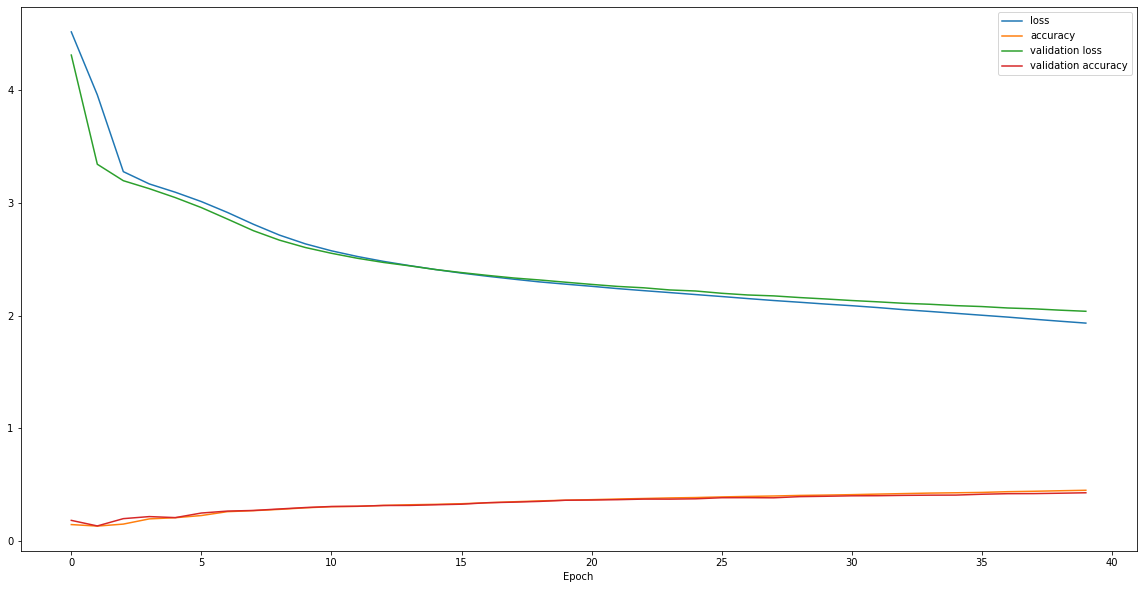

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist_custom.history["loss"], label='loss')
ax.plot(hist_custom.history["accuracy"], label='accuracy')
ax.plot(hist_custom.history["val_loss"], label='validation loss')
ax.plot(hist_custom.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

In [ ]:
def create_text(amount_symbols, init_text, text_model):    
    # Tokenize text
    ret = tokenize(init_text)
    
    states = None
    current_char = one_hot.encode(ret, dtype=float)
    # For some reason we have to add one dimension
    current_char = current_char.reshape(1, *current_char.shape)
    
    for i in range(amount_symbols):
        current_char, states = text_model(current_char, return_state = True, states = states)
        # Only add last char if several got 
        ret.append(one_hot.decode(current_char[0])[-1])
        
    return untokenize(ret)
    

In [ ]:
created_text = create_text(250, "Sport", literatur_model)

print(created_text)

Sporten ieie e et ieie e  i in n n ne in nenene en neneneneneneneneneneieie eteieie e et i in n ne in n nene en nenenenen neneneneneieie eteieieie et i in n ne i en nene en nenenenen neneneneneneie eteieieie et i ie n ne i en n ne en nenene en nenenenenen
